In [1]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame
from pandas.tools.plotting import scatter_matrix

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# get train & test csv files as a DataFrame
titanic_df = pd.read_csv("../Data/train.csv", dtype={"Age": np.float64}, )
test_df    = pd.read_csv("../Data/test.csv", dtype={"Age": np.float64}, )

## Basic Cleaning ##

Drop unnecessary columns or rows that won't be useful in analysis and prediction

- Remove PassengerId from train as it is an index and has no value. 
- Cabin might be a potential for removing given there are so many missing values however we need to investigate it further.
- Remove the 2 entries from the training set with missing Embarked values as the % of entries it impacts is so low.

In [3]:
titanic_df = titanic_df.drop(['PassengerId'], axis=1)
titanic_df = titanic_df.dropna(subset=['Embarked'])
# titanic_df.info() # verify

In [4]:
# Sex

# Convert string values to numerical one 
titanic_df['Sex'] = titanic_df['Sex'].map({'male':1,'female':0}).astype(int)
test_df['Sex'] = test_df['Sex'].map({'male':1,'female':0}).astype(int)

# Age

# Replace empty age values with the mean - should verify mean / median. Perhaps take by analysing
# name to determin title e.g. Mrs. is probably older than Miss.
titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)
test_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)

# TODO: Visualise and Analyse
# Name
# Age
# SibSp
# Parch
# Ticket
# Fare

# replace missing fare value with the mean.
titanic_df.Fare.fillna(titanic_df.Fare.mean(),inplace=True)
test_df.Fare.fillna(test_df.Fare.mean(),inplace=True)
    
# Cabin
# Embarked

In [5]:
# Verify totals
print("Survived: " + str(len(titanic_df[titanic_df['Survived'] == 1])))
print("Died: " + str(len(titanic_df[titanic_df['Survived'] == 0])))
print("Total: " + str(len(titanic_df)))


Survived: 340
Died: 549
Total: 889


## Create New Features ##

In [6]:
# TODO:

## Final correction of data ##

We need to remove some values such as string entries. Most of this code should be done smarter elsewhere!

In [7]:
# drop string values - these should be convirted
titanic_df = titanic_df.drop(["Name", "Ticket", "Cabin", "Embarked"],axis=1)
titanic_df = titanic_df.dropna()
test_df = test_df.drop(["Name", "Ticket", "Cabin", "Embarked"],axis=1)
test_df = test_df.dropna()


## Create Final Train and Test Datasets ##

In [8]:
# define training and testing sets

X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

## Build Models and Test ##
First some helper methods

In [9]:
# Run and evaluate model
def evaluate_model(model, X_train, Y_train, X_test):
    # fit the model against the training data
    model.fit(X_train, Y_train)

    # get scores based upon 5 fold cross validation
    scores = cross_validation.cross_val_score(model, X_train, Y_train, cv=5)
    print("Fold Accuracies: " + str(scores))
    print("Accuracy: %0.2f (+/- %0.2f @2std)" % (scores.mean(), scores.std() * 2))

    # Compute confusion matrix
    prediction = cross_validation.cross_val_predict(model, X_train, Y_train)
    cm = confusion_matrix(Y_train, prediction)
    print('Confusion matrix, without normalization')
    print(cm)
    plot_confusion_matrix(cm, np.array(["Died", "Survived"]))

    # predics test classes
    Y_pred = model.predict(X_test)
    return Y_pred

# Plot confusion matrix
def plot_confusion_matrix(cm, tickLabels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(tickLabels))
    plt.xticks(tick_marks, tickLabels, rotation=45)
    plt.yticks(tick_marks, tickLabels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Baseline (ZeroR) classification ##

At this stage out training set has **889** entries of which the most common output class is that they died with **549** entries.

We could achieve an accuracy of **61.75%** by just predicting 'died' for all cases so this should be our absolute baseline! 

Fold Accuracies: [ 0.79213483  0.79213483  0.78089888  0.76404494  0.81920904]
Accuracy: 0.79 (+/- 0.04 @2std)
Confusion matrix, without normalization
[[475  74]
 [110 230]]


,Features,Coefficient Estimate
0,Pclass,-0.829507
1,Sex,-2.503096
2,Age,-0.028848
3,SibSp,-0.308117
4,Parch,-0.087863
5,Fare,0.005017


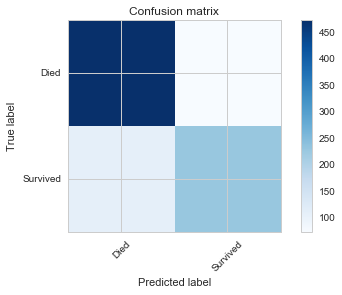

In [10]:
# Logistic Regression

logreg = LogisticRegression()
Y_predLogisticRegression = evaluate_model(logreg, X_train, Y_train, X_test)

# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(titanic_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

Fold Accuracies: [ 0.61235955  0.65168539  0.73595506  0.74719101  0.72881356]
Accuracy: 0.70 (+/- 0.11 @2std)
Confusion matrix, without normalization
[[457  92]
 [183 157]]


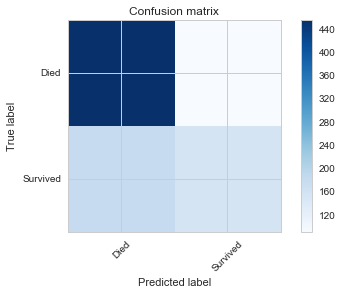

In [11]:
# Support Vector Machines

svc = SVC()
Y_predSVC = evaluate_model(svc, X_train, Y_train, X_test)

Fold Accuracies: [ 0.76404494  0.81460674  0.85955056  0.7752809   0.84180791]
Accuracy: 0.81 (+/- 0.07 @2std)
Confusion matrix, without normalization
[[474  75]
 [ 89 251]]


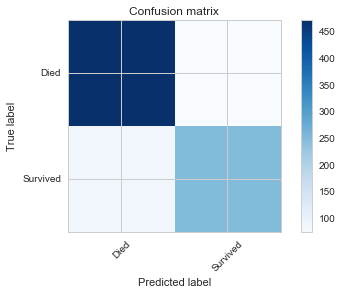

In [12]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100)
Y_predRandomForest = evaluate_model(random_forest, X_train, Y_train, X_test)

Fold Accuracies: [ 0.65168539  0.67977528  0.73033708  0.76404494  0.70621469]
Accuracy: 0.71 (+/- 0.08 @2std)
Confusion matrix, without normalization
[[426 123]
 [152 188]]


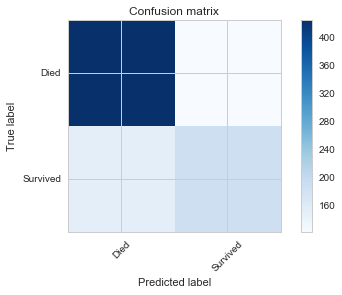

In [13]:
# K Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors = 3)
Y_predKNeighbors = evaluate_model(knn, X_train, Y_train, X_test)

Fold Accuracies: [ 0.75842697  0.80337079  0.79213483  0.78651685  0.79661017]
Accuracy: 0.79 (+/- 0.03 @2std)
Confusion matrix, without normalization
[[459  90]
 [102 238]]


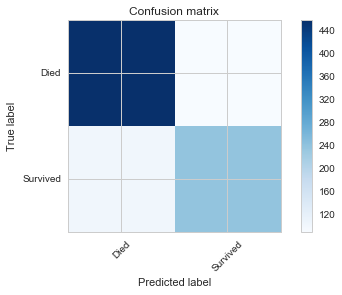

In [14]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
Y_predGaussian = evaluate_model(gaussian, X_train, Y_train, X_test)

## Create Submission File ##

In [15]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_predRandomForest
    })
submission.to_csv('predictions.csv', index=False)